To avoid to replication of jianhao's work, this notebook will work on analyzing the text features `URL`, `Domain`, and features derived from these. Remove HTML features first.

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy.stats import ttest_ind
import sklearn

In [101]:
df = pd.read_csv('../dataset/PhiUSIIL_Phishing_URL_Dataset.csv')
cols_to_remove = ['LargestLineLength', 'HasTitle', 'HasFavicon', 'IsResponsive', 'NoOfURLRedirect', 
                  'HasDescription', 'NoOfPopup', 'NoOfiFrame', 'HasExternalFormSubmit', 'HasCopyrightInfo', 
                  'HasSocialNet', 'HasPasswordField', 'HasSubmitButton', 'HasHiddenFields', 'Bank', 'Pay', 
                  'Crypto', 'NoOfImage', 'NoOfJS', 'NoOfSelfRef', 'NoOfEmptyRef', 'NoOfExternalRef',
                  'NoOfSelfRedirect', 'NoOfCSS', 'Robots', 'LineOfCode', 'FILENAME', 'Title',
                  'DomainTitleMatchScore', 'URLTitleMatchScore']


df_remaining = df.copy()
df_remaining = df_remaining.drop(columns=cols_to_remove)

## Basic Features
Start with basic features (no interactions or ratios)

In [102]:
# URL is the original input with everything
cols_from_url = ['URL', 'URLLength', 'NoOfSubDomain', 'NoOfObfuscatedChar', 'IsHTTPS',
                 'NoOfLettersInURL', 'NoOfDegitsInURL', 'NoOfEqualsInURL', 'NoOfQMarkInURL',
                 'NoOfAmpersandInURL', 'NoOfOtherSpecialCharsInURL', 'HasObfuscation']

# Domain is derived from URL, e.g. url: http://example.com/path -> domain: example.com
cols_from_domain = ['Domain', 'DomainLength', 'IsDomainIP', ]

# TLD (Top-Level Domain) is derived from Domain, e.g. domain: example.com -> TLD: com
cols_from_TLD = ['TLD', 'TLDLength']

### Numeric URL Features

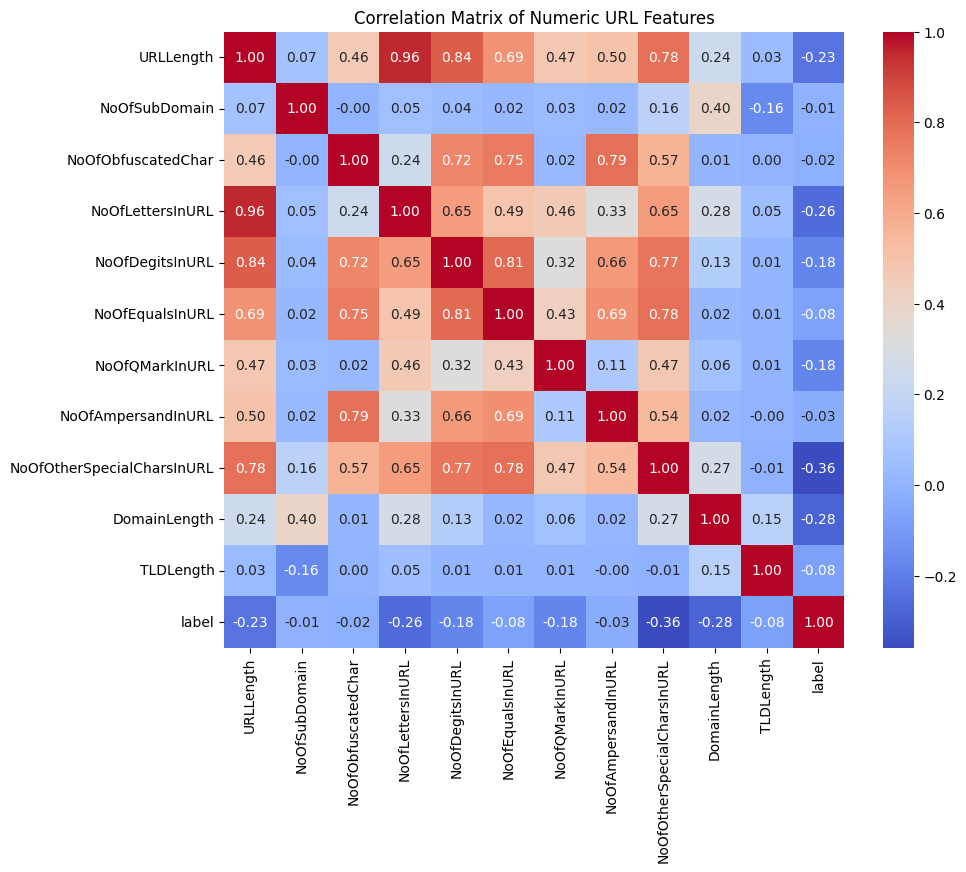

In [45]:
num_url_features = ['URLLength', 'NoOfSubDomain', 'NoOfObfuscatedChar', 'NoOfLettersInURL',
                    'NoOfDegitsInURL', 'NoOfEqualsInURL', 'NoOfQMarkInURL', 'NoOfAmpersandInURL',
                    'NoOfOtherSpecialCharsInURL', 'DomainLength', 'TLDLength']

corr_matrix = df[num_url_features + ['label']].corr(method='pearson')

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numeric URL Features')
plt.show()

Counts + length of URL seem to be inversely related to phishing, shorter URLs are more likely phishing URLs. Most strongly negatively correlated is special characters.

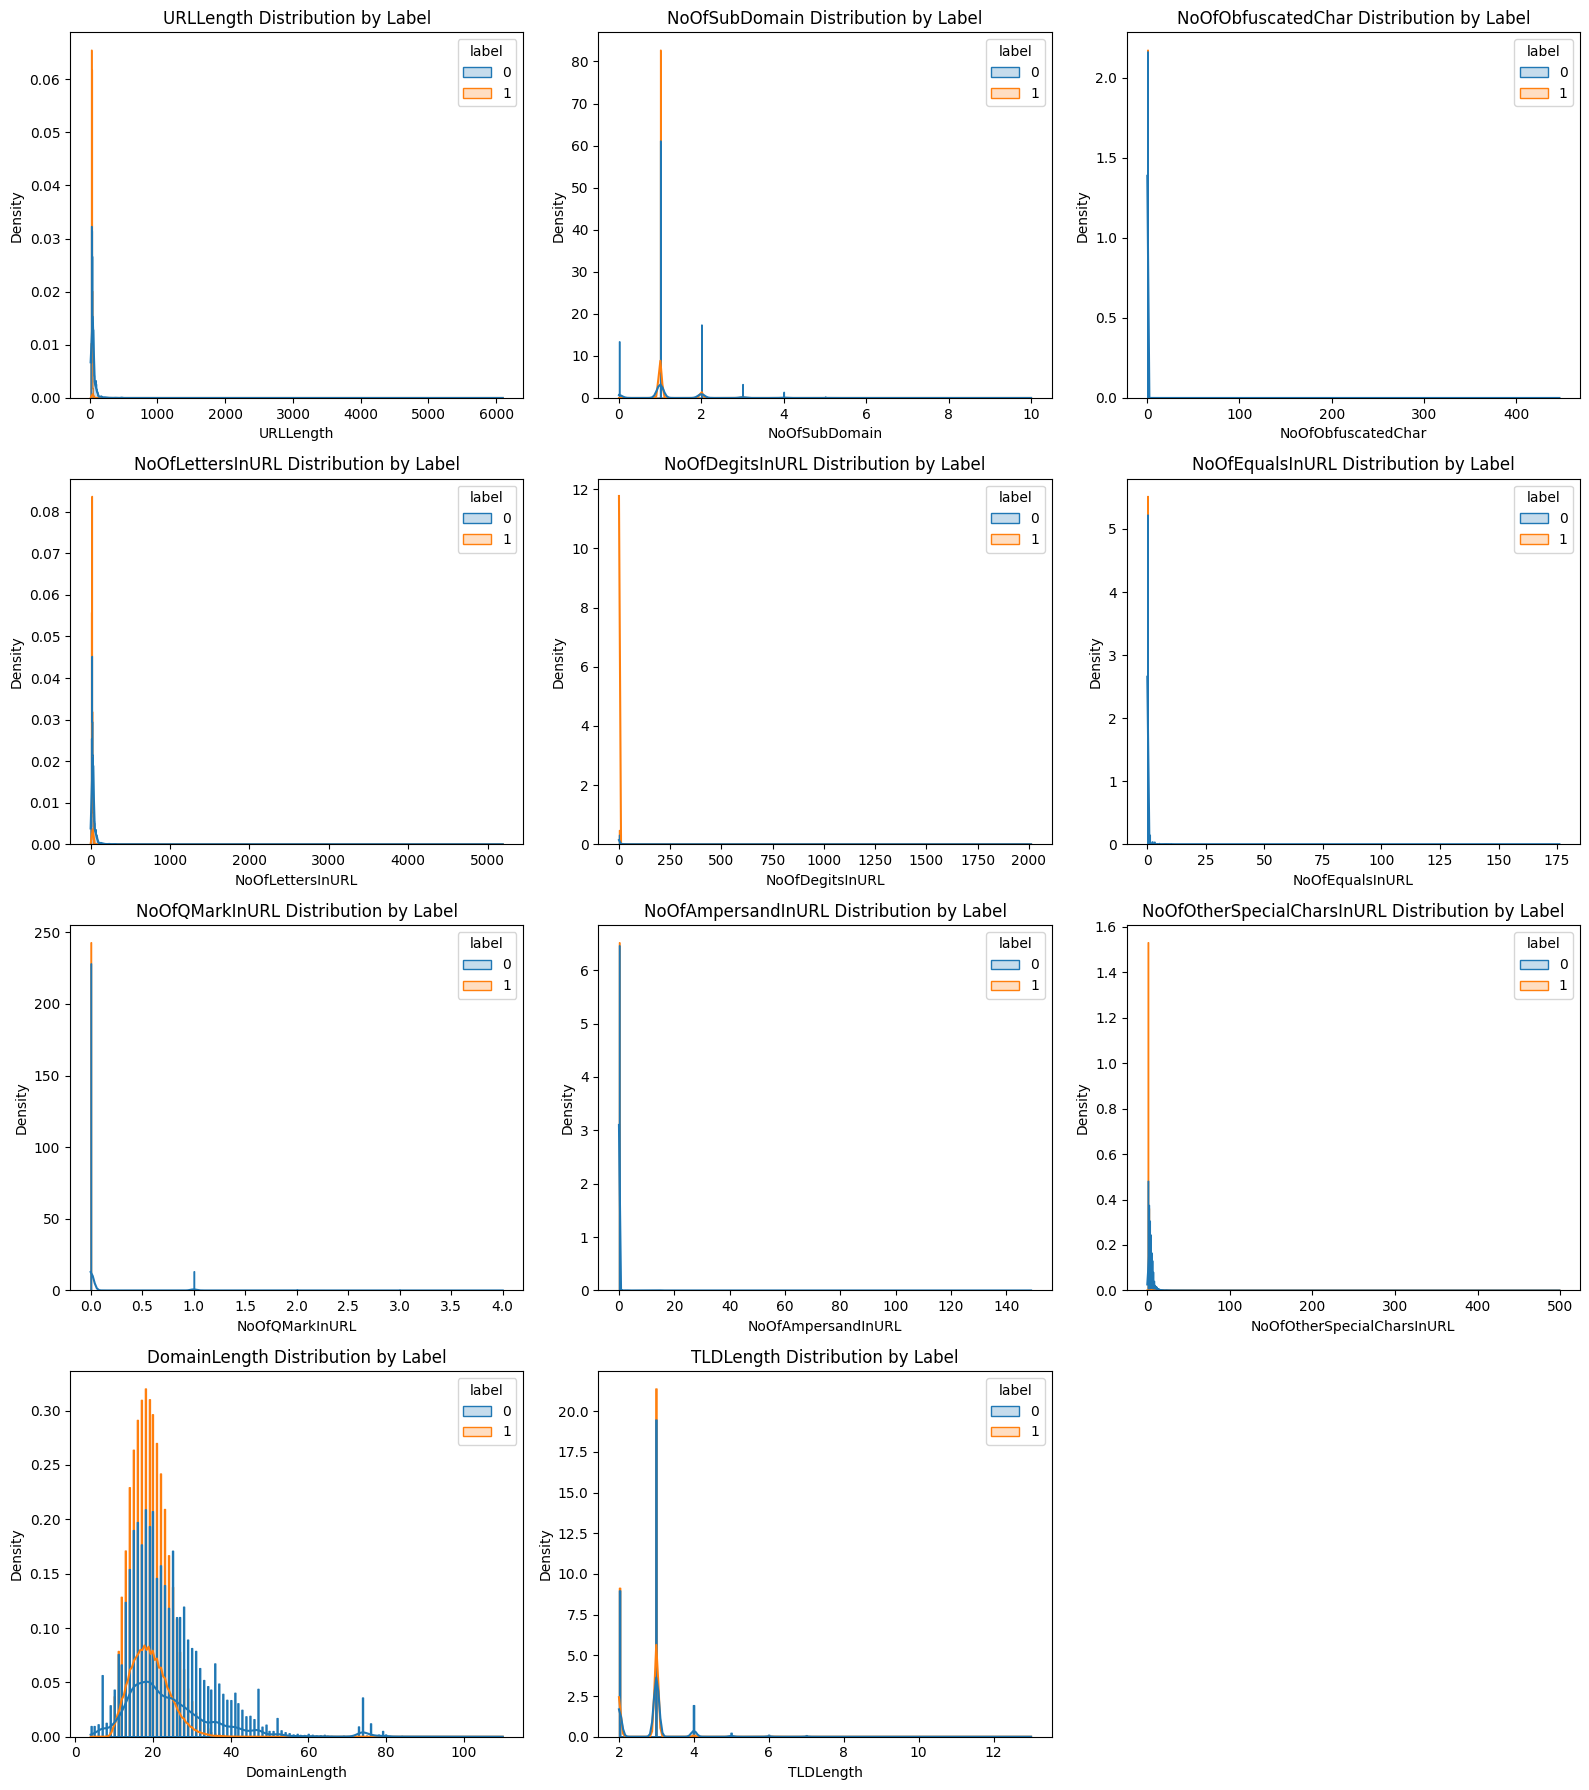

In [55]:
plt.figure(figsize=(16, 18))
for i, col in enumerate(num_url_features):
    plt.subplot(4, 3, i+1)
    sns.histplot(data=df, x=col, hue='label', kde=True, element='step', stat='density', common_norm=False)
    plt.title(f'{col} Distribution by Label')
plt.tight_layout()
plt.show()

Nothing really meaningful except that distribution of phishing sites (`label=1`) roughly follow distributions of non phishing sites (`label=0`)

Maybe this means that we can remove outliers in these cols or drop them if they don't provide meaningful information.

Run random forest to check feature importance.

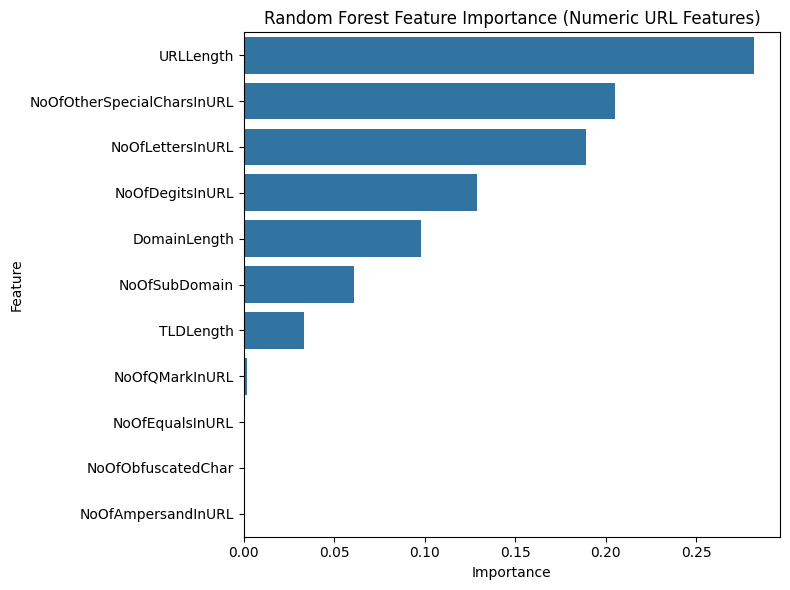

Random Forest Accuracy: 0.9965
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     20124
           1       1.00      1.00      1.00     27035

    accuracy                           1.00     47159
   macro avg       1.00      1.00      1.00     47159
weighted avg       1.00      1.00      1.00     47159

Confusion Matrix:
[[20009   115]
 [   50 26985]]


In [63]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

X = df[num_url_features]
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

importances = rf.feature_importances_
feature_importance = pd.Series(importances, index=num_url_features).sort_values(ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(x=feature_importance.values, y=feature_importance.index)
plt.title('Random Forest Feature Importance (Numeric URL Features)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

y_pred = rf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Random Forest Accuracy: {acc:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

From here we notice that `URLLength` has the highest importance, followed by `NoOfOtherSpecialCharsInURL` (0.78 correlation with `URLLength`), then `NoOflettersInURL` (0.96 correlation with`URLLength`).

All of the top features are highly correlated to URLLength which gives the impression that URLLength is especially important in predicting whether or not the URL is a phishing site.

Apart from this, the highest ranked feature that is less correlated with `URLLength` is `DomainLength` at 0.24.

### Categorical URL Features

In [104]:
categorical_cols = ['IsHTTPS', 'IsDomainIP', 'HasObfuscation']

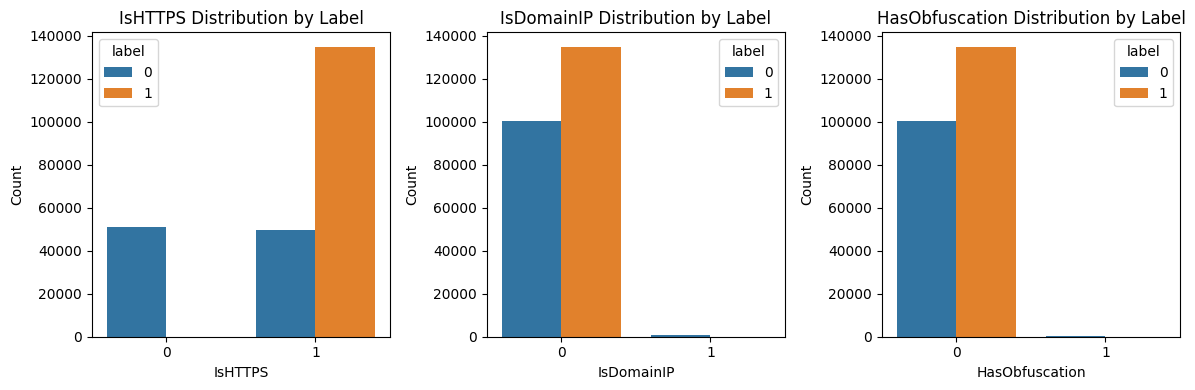

In [84]:
plt.figure(figsize=(12, 4))
for i, col in enumerate(categorical_cols):
    plt.subplot(1, 3, i+1)
    sns.countplot(data=df, x=col, hue='label')
    plt.title(f'{col} Distribution by Label')
    plt.xlabel(col)
    plt.ylabel('Count')
plt.tight_layout()
plt.show()

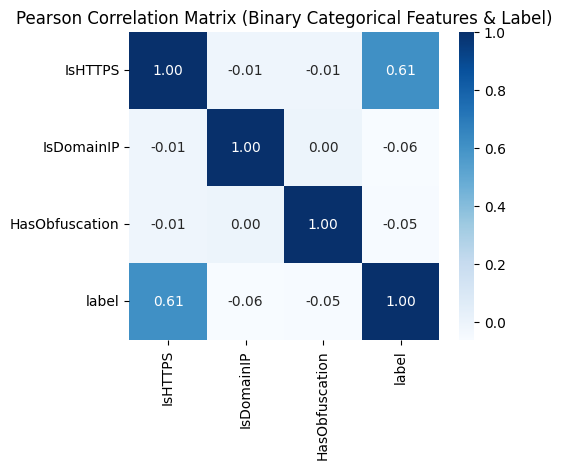

Chi-square test for IsHTTPS: chi2=87486.79, p-value=0.0000e+00
Chi-square test for IsDomainIP: chi2=852.26, p-value=2.3448e-187
Chi-square test for HasObfuscation: chi2=646.90, p-value=1.0569e-142


In [83]:
from scipy.stats import chi2_contingency

# Pearson correlation for binary categorical features against label
corr_matrix = df[categorical_cols + ['label']].corr(method='pearson')

plt.figure(figsize=(5, 4))
sns.heatmap(corr_matrix, annot=True, cmap='Blues', fmt=".2f")
plt.title("Pearson Correlation Matrix (Binary Categorical Features & Label)")
plt.show()

for col in categorical_cols:
    contingency_table = pd.crosstab(df[col], df['label'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    print(f"Chi-square test for {col}: chi2={chi2:.2f}, p-value={p:.4e}")

From here we see that `IsHTTPS` is highly correlated to label, while all the categoricals are not really correlated to each other (probably less multicollinearity if it matters for non rf models)

Chi-square is still significant for all 3, with `IsHTTPS` being the highest. All three will probably be useful predictors of `label`.

Regarding Jian Hao's notebook on zero variance groups -> I feel like these are strong predictors, maybe need to regularize to prevent model from giving these features too high gain.

XGBoost params for these are:

`min_child_weight` and `gamma` will discourage splits on features that look “too good to be true.”

`lambda` (L2 regularization) and `alpha` (L1 regularization) shrink leaf scores so one feature doesn’t dominate.

`eta` + `subsample` make the model spread learning across many features/trees.

In [103]:
cols_to_remove = cols_from_url + cols_from_domain + cols_from_TLD
df_remaining = df_remaining.drop(columns=cols_to_remove)
df_remaining.isna().sum()

URLSimilarityIndex       0
CharContinuationRate     0
TLDLegitimateProb        0
URLCharProb              0
ObfuscationRatio         0
LetterRatioInURL         0
DegitRatioInURL          0
SpacialCharRatioInURL    0
label                    0
dtype: int64

## Interaction features 
Include interactions between 2 or more features like ratios

In [105]:
interaction_cols = ['ObfuscationRatio', 'LetterRatioInURL', 'DegitRatioInURL', 'SpacialCharRatioInURL']

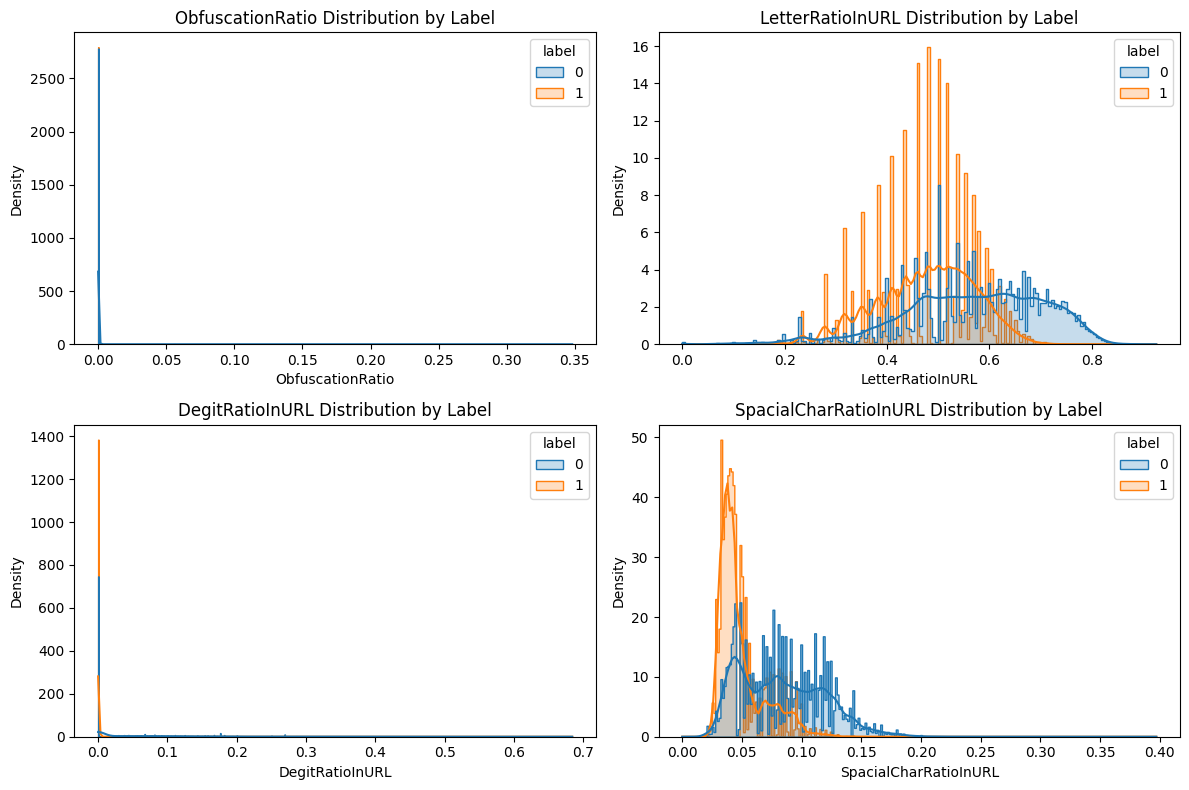

In [96]:
plt.figure(figsize=(12, 8))
for i, col in enumerate(interaction_cols):
    plt.subplot(2, 2, i+1)
    sns.histplot(data=df, x=col, hue='label', kde=True, element='step', stat='density', common_norm=False)
    plt.title(f'{col} Distribution by Label')
plt.tight_layout()
plt.show()

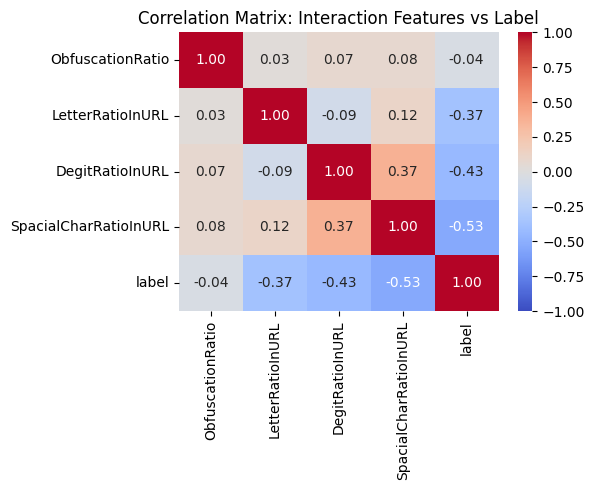

In [97]:
# Correlation matrix for interaction features vs label
corr_matrix_interactions = df[interaction_cols + ['label']].corr(method='pearson')

plt.figure(figsize=(6, 5))
sns.heatmap(corr_matrix_interactions, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title('Correlation Matrix: Interaction Features vs Label')
plt.tight_layout()
plt.show()

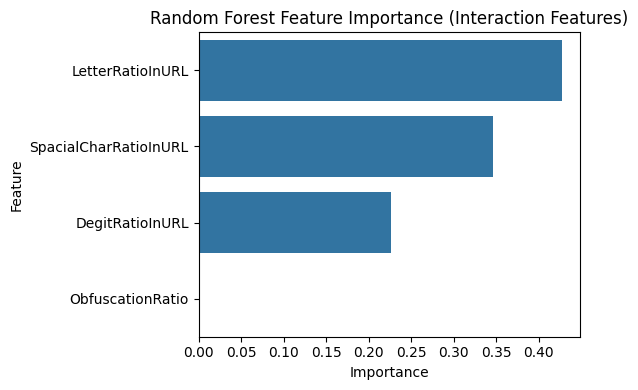

Random Forest Accuracy (Interaction Features): 0.9927
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     20124
           1       0.99      1.00      0.99     27035

    accuracy                           0.99     47159
   macro avg       0.99      0.99      0.99     47159
weighted avg       0.99      0.99      0.99     47159

Confusion Matrix:
[[19853   271]
 [   73 26962]]


In [98]:
X_interaction = df[interaction_cols]
y_interaction = df['label']

X_train_inter, X_test_inter, y_train_inter, y_test_inter = train_test_split(X_interaction, y_interaction, test_size=0.2, random_state=42)

rf_inter = RandomForestClassifier(n_estimators=100, random_state=42)
rf_inter.fit(X_train_inter, y_train_inter)

importances_inter = rf_inter.feature_importances_
feature_importance_inter = pd.Series(importances_inter, index=interaction_cols).sort_values(ascending=False)

plt.figure(figsize=(6, 4))
sns.barplot(x=feature_importance_inter.values, y=feature_importance_inter.index)
plt.title('Random Forest Feature Importance (Interaction Features)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

y_pred_inter = rf_inter.predict(X_test_inter)
acc_inter = accuracy_score(y_test_inter, y_pred_inter)
print(f"Random Forest Accuracy (Interaction Features): {acc_inter:.4f}")
print("Classification Report:")
print(classification_report(y_test_inter, y_pred_inter))
print("Confusion Matrix:")
print(confusion_matrix(y_test_inter, y_pred_inter))

Idk what to make of these interaction features

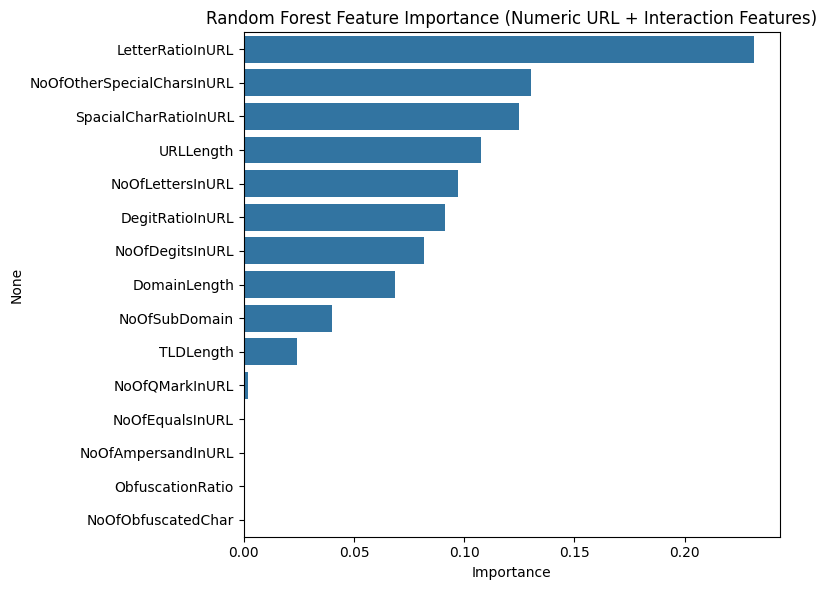

Random Forest Accuracy (All Features): 0.9971

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     20124
           1       1.00      1.00      1.00     27035

    accuracy                           1.00     47159
   macro avg       1.00      1.00      1.00     47159
weighted avg       1.00      1.00      1.00     47159

Confusion Matrix:
[[20021   103]
 [   36 26999]]


In [100]:
# Combine numeric URL features and interaction features using the existing train/test splits
X_train_all = pd.concat([X_train, X_train_inter], axis=1)
X_test_all = pd.concat([X_test, X_test_inter], axis=1)

# Train Random Forest on all features
rf_all = RandomForestClassifier(n_estimators=100, random_state=42)
rf_all.fit(X_train_all, y_train)

# Feature importances
feature_importance_all = pd.Series(rf_all.feature_importances_, index=X_train_all.columns).sort_values(ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(x=feature_importance_all.values, y=feature_importance_all.index)
plt.title('Random Forest Feature Importance (Numeric URL + Interaction Features)')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

# Model performance
y_pred_all = rf_all.predict(X_test_all)
acc_all = accuracy_score(y_test, y_pred_all)
print(f"Random Forest Accuracy (All Features): {acc_all:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_all))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_all))

i guess interaction features are more useful than the original url numerical features that they were derived from.

`LetterRatioInURL` > `NoOfLettersInURL`

`DegitRatioInURL` > `NoOfDegitsInURL`

`ObfuscationRatio` = `NoOfObfuscatedChar` = 0

can probably ignore obfuscation & obfuscated characters

In [106]:
cols_to_remove = interaction_cols
df_remaining = df_remaining.drop(columns=cols_to_remove)
df_remaining.isna().sum()

URLSimilarityIndex      0
CharContinuationRate    0
TLDLegitimateProb       0
URLCharProb             0
label                   0
dtype: int64

## Derived Features
Include more complex features that are listed as derived features from the paper.

**URLSimilarityIndex:**
How similar the url is to a top visited website, looking at 10 million sites from Open PageRank. I don't get the math calculation for this.

**CharContinuationRate:**
Sum of longest alphabet, digit, and special character sequences divided by totaled length of URL. URLs such as www.abc.com, www.abc123.com, or www.abc_123.com can give one CharContinuationRate value. However, URLs such as www.a1b2c3.com or www.a1_b-_2.com get lower CharContinuationRate

**TLDLegitimateProb:**
How common the top level domain is (.com, .sg, .us, etc.) calculated out of the top 10 million sites.

In [107]:
derived_cols = ['URLSimilarityIndex', 'CharContinuationRate', 'TLDLegitimateProb', 'URLCharProb']

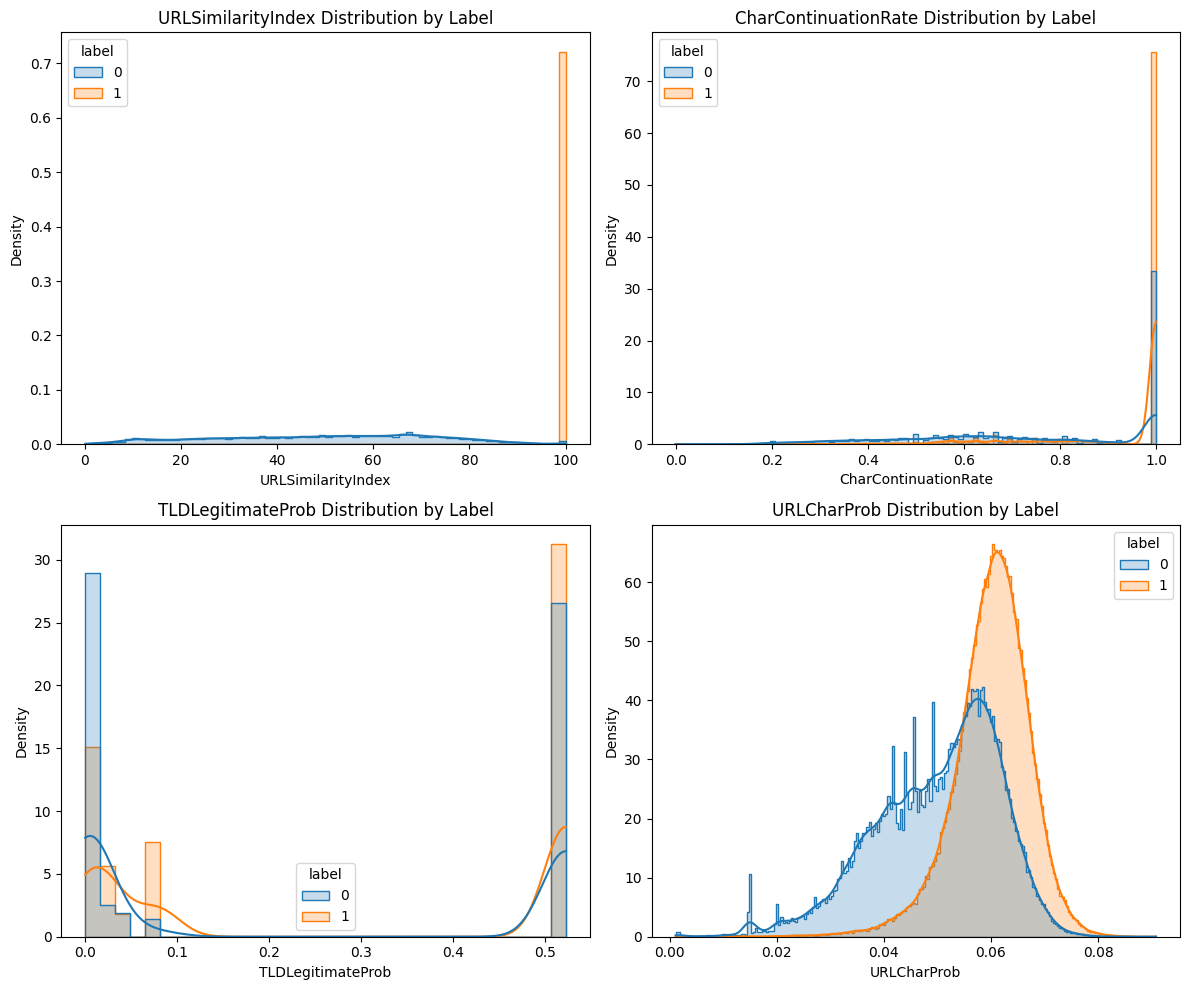

In [108]:
plt.figure(figsize=(12, 10))
for i, col in enumerate(derived_cols):
    plt.subplot(2, 2, i+1)
    sns.histplot(data=df, x=col, hue='label', kde=True, element='step', stat='density', common_norm=False)
    plt.title(f'{col} Distribution by Label')
plt.tight_layout()
plt.show()

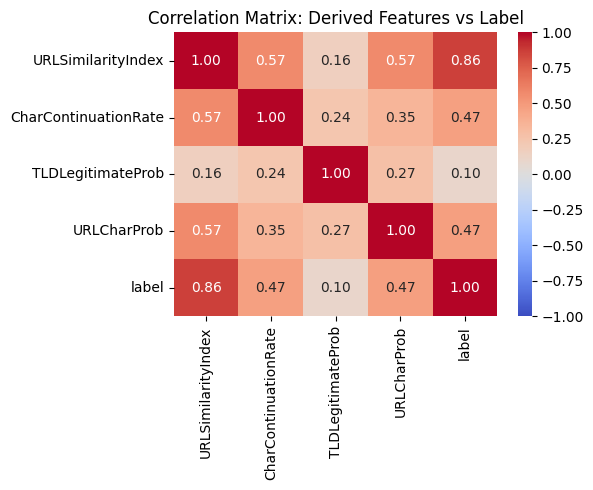

In [110]:
corr_matrix_derived = df[derived_cols + ['label']].corr(method='pearson')

plt.figure(figsize=(6, 5))
sns.heatmap(corr_matrix_derived, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title('Correlation Matrix: Derived Features vs Label')
plt.tight_layout()
plt.show()

Everything is quite correlated to label except TLDLegitimateProb, ig maybe alot of scam sites use common TLDs like .com or sth.

/var/folders/tg/0n0rjzh11yd7zhlhtlf2g84r0000gn/T/ipykernel_83627/4138610131.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feat_imp_derived.values, y=feat_imp_derived.index, palette="viridis")


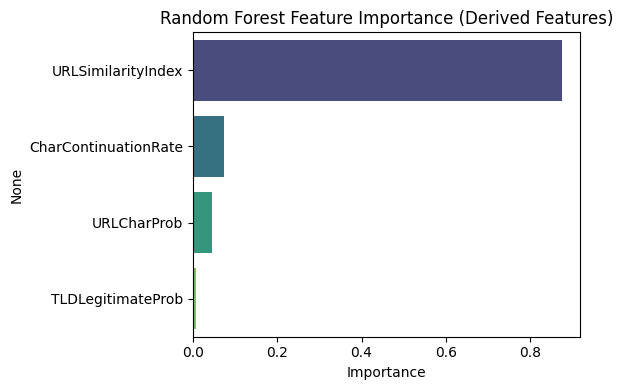

Random Forest Accuracy (Derived Features): 0.9948

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     20124
           1       0.99      1.00      1.00     27035

    accuracy                           0.99     47159
   macro avg       0.99      0.99      0.99     47159
weighted avg       0.99      0.99      0.99     47159

Confusion Matrix:
[[19974   150]
 [   93 26942]]


In [111]:
# Random Forest on derived features vs label
X_derived = df[derived_cols]
y_derived = df['label']

X_train_der, X_test_der, y_train_der, y_test_der = train_test_split(
    X_derived, y_derived, test_size=0.2, random_state=42
)

rf_derived = RandomForestClassifier(n_estimators=100, random_state=42)
rf_derived.fit(X_train_der, y_train_der)

# Feature importances
importances_derived = rf_derived.feature_importances_
feat_imp_derived = pd.Series(importances_derived, index=derived_cols).sort_values(ascending=False)

plt.figure(figsize=(6, 4))
sns.barplot(x=feat_imp_derived.values, y=feat_imp_derived.index, palette="viridis")
plt.title('Random Forest Feature Importance (Derived Features)')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

# Model performance
y_pred_der = rf_derived.predict(X_test_der)
acc_derived = accuracy_score(y_test_der, y_pred_der)

print(f"Random Forest Accuracy (Derived Features): {acc_derived:.4f}\n")
print("Classification Report:")
print(classification_report(y_test_der, y_pred_der))
print("Confusion Matrix:")
print(confusion_matrix(y_test_der, y_pred_der))

Similar insights as above

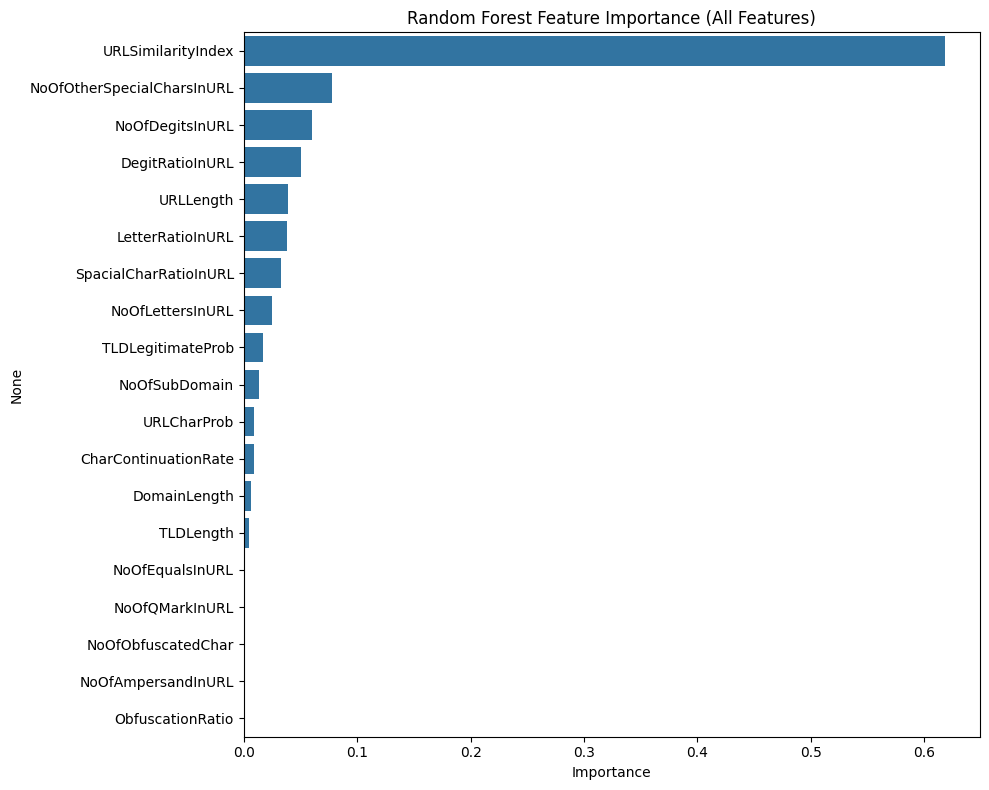

Random Forest Accuracy (All Features): 0.9992

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     20124
           1       1.00      1.00      1.00     27035

    accuracy                           1.00     47159
   macro avg       1.00      1.00      1.00     47159
weighted avg       1.00      1.00      1.00     47159

Confusion Matrix:
[[20086    38]
 [    1 27034]]


In [112]:
# Combine all features for Random Forest
all_feature_cols = derived_cols + num_url_features + interaction_cols
X_all_features = df[all_feature_cols]
y_all_features = df['label']

X_train_all_features, X_test_all_features, y_train_all_features, y_test_all_features = train_test_split(
    X_all_features, y_all_features, test_size=0.2, random_state=42
)

rf_all_features = RandomForestClassifier(n_estimators=100, random_state=42)
rf_all_features.fit(X_train_all_features, y_train_all_features)

# Feature importances
feature_importance_all_features = pd.Series(
    rf_all_features.feature_importances_, index=all_feature_cols
).sort_values(ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x=feature_importance_all_features.values, y=feature_importance_all_features.index)
plt.title('Random Forest Feature Importance (All Features)')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

# Model performance
y_pred_all_features = rf_all_features.predict(X_test_all_features)
acc_all_features = accuracy_score(y_test_all_features, y_pred_all_features)
print(f"Random Forest Accuracy (All Features): {acc_all_features:.4f}\n")
print("Classification Report:")
print(classification_report(y_test_all_features, y_pred_all_features))
print("Confusion Matrix:")
print(confusion_matrix(y_test_all_features, y_pred_all_features))

URLSimilarityIndex is really good predictor, others are on par with the weaker numerical features.

## New Feature Ideas

TF-IDF

In [113]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Embed URL text into numeric features using character n-gram TF-IDF + dimensionality reduction (SVD),
# then append embeddings to existing feature matrices and evaluate a RandomForest quickly.


# configure
ngram_range = (3, 6)        # char n-grams to capture token/obfuscation patterns
max_tfidf_feats = 20000     # cap vocabulary
svd_components = 50         # number of dense dimensions for URL embedding

# extract URL strings for train/test using existing indices (no leakage)
urls_train = df.loc[X_train_all_features.index, 'URL']
urls_test = df.loc[X_test_all_features.index, 'URL']

# TF-IDF on character n-grams
vec = TfidfVectorizer(analyzer='char', ngram_range=ngram_range, max_features=max_tfidf_feats)
X_url_train_sparse = vec.fit_transform(urls_train)
X_url_test_sparse  = vec.transform(urls_test)

# reduce to dense embedding
svd = TruncatedSVD(n_components=svd_components, random_state=42)
X_url_train_emb = svd.fit_transform(X_url_train_sparse)
X_url_test_emb  = svd.transform(X_url_test_sparse)

# build DataFrames for easy joining (preserve original indices)
url_emb_cols = [f'url_emb_{i}' for i in range(svd_components)]
df_url_train_emb = pd.DataFrame(X_url_train_emb, index=urls_train.index, columns=url_emb_cols)
df_url_test_emb  = pd.DataFrame(X_url_test_emb,  index=urls_test.index,  columns=url_emb_cols)

# join embeddings to existing feature sets (X_train_all_features / X_test_all_features)
X_train_url = X_train_all_features.join(df_url_train_emb)
X_test_url  = X_test_all_features.join(df_url_test_emb)

print("Shapes:", X_train_all_features.shape, "->", X_train_url.shape, "|", X_test_all_features.shape, "->", X_test_url.shape)

# quick model check (reuse RandomForestClassifier style used earlier)
rf_url = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_url.fit(X_train_url, y_train_all_features)
y_pred_url = rf_url.predict(X_test_url)
acc_url = accuracy_score(y_test_all_features, y_pred_url)
print(f"Random Forest accuracy with URL embeddings appended: {acc_url:.4f}")

# optional: inspect how much variance SVD explained (first components)
explained = svd.explained_variance_ratio_.sum()
print(f"SVD explained variance ratio (sum of {svd_components} comps): {explained:.3f}")

Shapes: (188636, 19) -> (188636, 69) | (47159, 19) -> (47159, 69)
Random Forest accuracy with URL embeddings appended: 0.9999
SVD explained variance ratio (sum of 50 comps): 0.177


wow high accuracy, some embeddings perform way better than alot of numericals

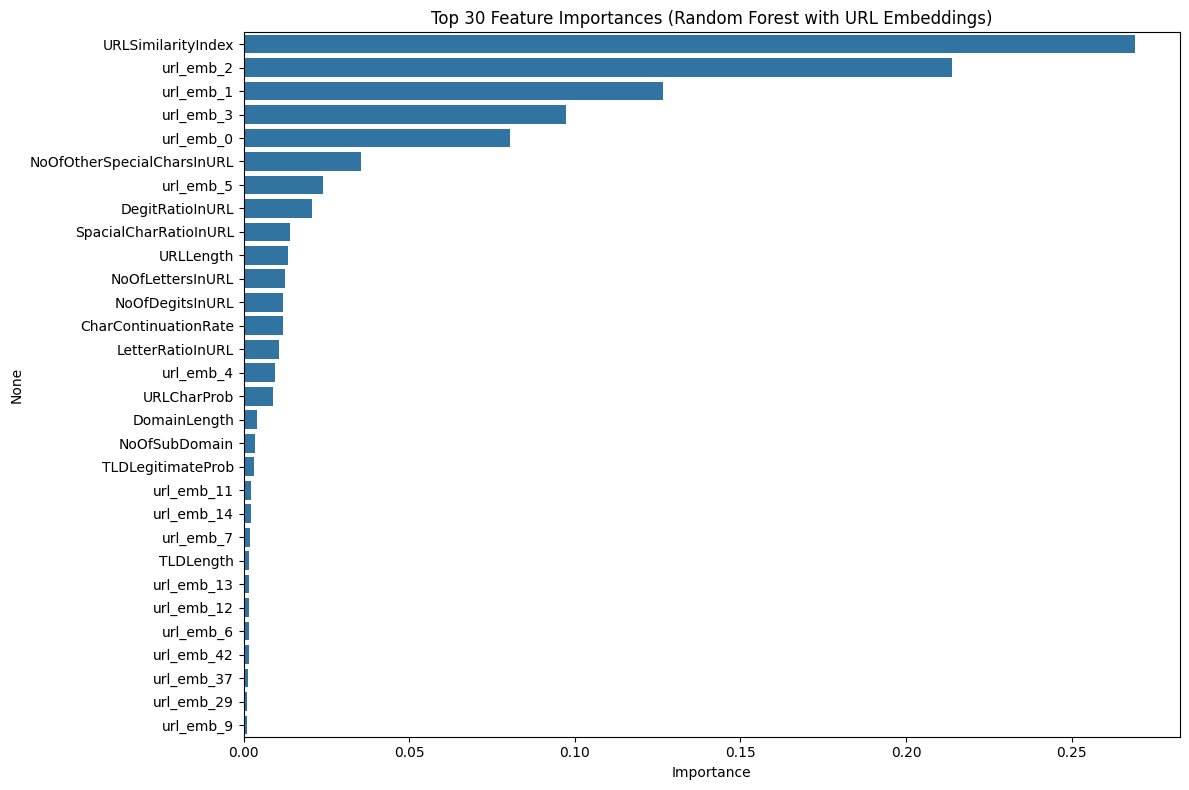

Random Forest accuracy with URL embeddings: 0.9999
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     20124
           1       1.00      1.00      1.00     27035

    accuracy                           1.00     47159
   macro avg       1.00      1.00      1.00     47159
weighted avg       1.00      1.00      1.00     47159

Confusion Matrix:
[[20119     5]
 [    0 27035]]


In [115]:
# Plot feature importances for rf_url (URL embeddings + all features)
importances_url = rf_url.feature_importances_
feature_names_url = list(X_train_url.columns)

feat_imp_url = pd.Series(importances_url, index=feature_names_url).sort_values(ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x=feat_imp_url.values[:30], y=feat_imp_url.index[:30])
plt.title('Top 30 Feature Importances (Random Forest with URL Embeddings)')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

# Print model performance
print(f"Random Forest accuracy with URL embeddings: {acc_url:.4f}")
print("Classification Report:")
print(classification_report(y_test_all_features, y_pred_url))
print("Confusion Matrix:")
print(confusion_matrix(y_test_all_features, y_pred_url))